# 1. Library & Seed Setting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import requests
import joblib
import pickle

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from tqdm import tqdm

plt.rcParams['font.family'] = 'NanumGothic'

In [130]:
def seed_setting(seed=1004) :
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_setting()

# 2. Data Load

In [131]:
bus_data = pd.read_csv("bus_feature.csv")
subway_data = pd.read_csv("subway_feature.csv")
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

/tmp/ipykernel_5798/2401849155.py:3: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("train.csv")


In [132]:
def base_preprocessing(df) :
    # 문자열 컬럼만 찾아서 좌우 공백 제거
    df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    # 전화번호, 팩스번호 k-홈페이지, 고용보험관리번호, k-등록일자, k-수정일자, 관리비 업로드, 단지소개기존clob 삭제
    df = df.drop(columns=['k-전화번호', 'k-팩스번호', 'k-홈페이지', '고용보험관리번호', 'k-등록일자', 'k-수정일자', '관리비 업로드', '단지소개기존clob'])

    # 본번, 부번, 시군구 삭제
    df = df.drop(columns=['본번', '부번', '시군구'])

    # 계약년월 분해
    df['계약(연)'] = df['계약년월'] // 100
    df['계약(월)'] = df['계약년월'] % 100
    df = df.drop(columns=['계약년월'])

    # 계약일 → 계약(일)
    df = df.rename(columns={"계약일" : "계약(일)"})

    # 불필요 특성 제거
    columns_to_keep = [
    '전용면적(㎡)', '건축년도', '해제사유발생일', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-전체세대수', '주차대수', '계약(연)', 
    '좌표X', '좌표Y', '아파트명', '등기신청일자', 'k-복도유형', 'k-단지분류(아파트,주상복합등등)', '도로명'
    ]

    df = df[columns_to_keep]
    
    return df

In [133]:
train_data = base_preprocessing(train_data)

In [134]:
train_data['주차대수'].isnull().sum()

869714

In [135]:
train_data['k-전체세대수'].isnull().sum()

869563

In [136]:
train_data.head(1)

,전용면적(㎡),건축년도,해제사유발생일,k-연면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-전체세대수,주차대수,계약(연),좌표X,좌표Y,아파트명,등기신청일자,k-복도유형,"k-단지분류(아파트,주상복합등등)",도로명
0,79.97,1987,NaN,22637.0,20.0,250.0,270.0,262.0,2017,127.05721,37.476763,개포6차우성,,계단식,아파트,언주로 3


In [137]:
def preprocessing(df) :
    # 해재사유발생일 전처리
    df['해제사유발생일'] = df['해제사유발생일'].notnull().astype(int)

    # 세대당_주차대수 특성 생성
    df['세대당_주차대수'] = df.apply(
    lambda row: row['주차대수'] / row['k-전체세대수'] if pd.notnull(row['주차대수']) and pd.notnull(row['k-전체세대수']) else np.nan,
    axis=1)

    # 등기신청일자 전처리
    df['등기신청일자'] = df['등기신청일자'].notnull().astype(int)

    # 특성 이름에서 k- 빼기
    df.columns = df.columns.str.replace('k-', '')

    return df

In [138]:
df = preprocessing(train_data)

In [139]:
df['아파트명'].isnull()

0          False
1          False
2          False
3          False
4          False
           ...  
1118817    False
1118818    False
1118819    False
1118820    False
1118821    False
Name: 아파트명, Length: 1118822, dtype: bool

In [140]:
def get_coords_kakao(address, api_key):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {"query": address}
    response = requests.get(url, headers=headers, params=params)
    result = response.json()
    
    try:
        x = float(result['documents'][0]['x'])
        y = float(result['documents'][0]['y'])
        return x, y
    except IndexError:
        return None, None

In [141]:
roadname_to_coords = {}
unique_roads = df.loc[df[['좌표X', '좌표Y']].isnull().any(axis=1), '도로명'].dropna().unique()

api_key = '13b7b7a0b7a853100b56c56f19f6bc24'

for road in tqdm(unique_roads) :
    x, y = get_coords_kakao(road, api_key)
    if x is not None and y is not None :
        roadname_to_coords[road] = (x, y)

100%|██████████| 8441/8441 [09:48<00:00, 14.35it/s]


In [142]:
def fill_missing_coords(row):
    if pd.isna(row['좌표X']) or pd.isna(row['좌표Y']):
        coords = roadname_to_coords.get(row['도로명'])
        if coords:
            return pd.Series(coords)
    return pd.Series([row['좌표X'], row['좌표Y']])

df[['좌표X', '좌표Y']] = df.apply(fill_missing_coords, axis=1)

In [143]:
df['좌표X'].isnull().sum()

22191

In [144]:
df = df.dropna(subset=['좌표X', '좌표Y'])

# 3. Clustering (군집화)

**좌표X**와 **좌표Y**를 이용하여 군집화를 수행한다.

군집이 형성되는게 목표이므로 결측치가 많더라도 전부 제거하고 수행한다.

In [145]:
coords = df[['좌표X', '좌표Y']].dropna()

/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

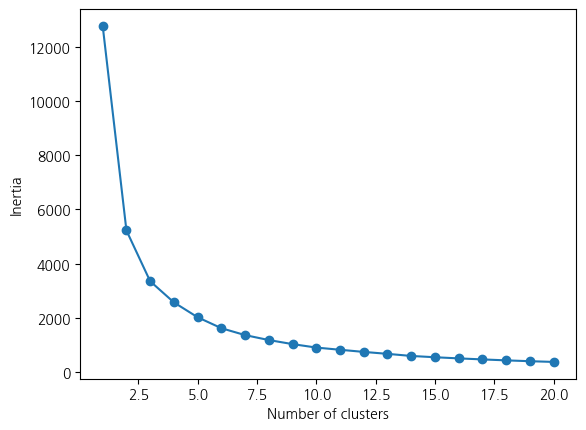

In [146]:
inertia = []
k = range(1, 21)

for i in k :
    kmeans = KMeans(n_clusters=i, random_state=1004)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

plt.plot(k, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [174]:
k_opt = 7

kmeans = KMeans(n_clusters=k_opt, random_state=1004)
df['cluster'] = kmeans.fit_predict(coords)

/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_5798/2270009418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(coords)


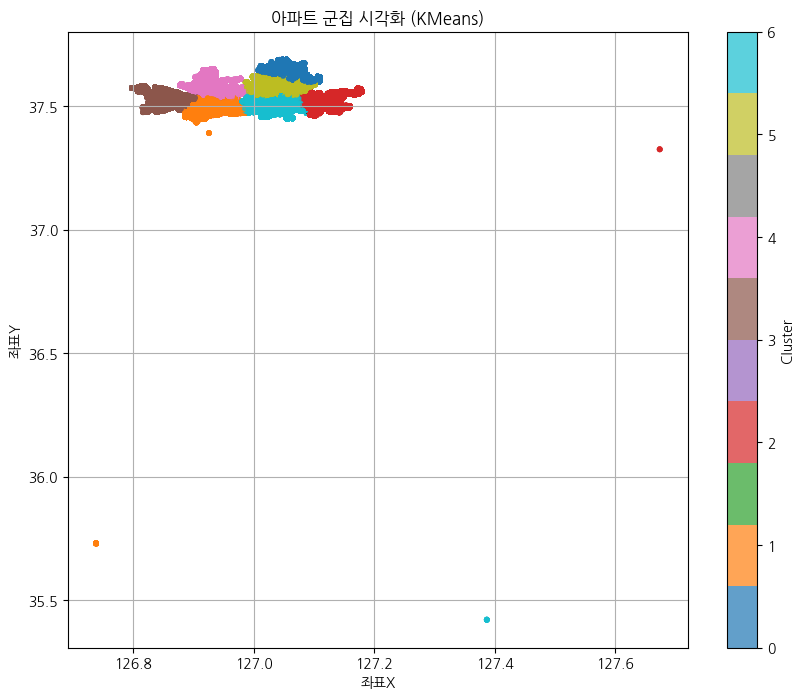

In [175]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['좌표X'], df['좌표Y'], c=df['cluster'], cmap='tab10', s=10, alpha=0.7)

plt.xlabel('좌표X')
plt.ylabel('좌표Y')
plt.title('아파트 군집 시각화 (KMeans)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

군집화 후 확인해보니 이상치가 발견된다. 이를 제거해주자.

In [176]:
centroids = kmeans.cluster_centers_

distances = np.linalg.norm(coords - centroids[df['cluster']], axis=1)

threshold = np.percentile(distances, 99)  # 상위 1% 이상치
df_clean = df[distances <= threshold]

In [193]:
coords_clean = df_clean[['좌표X', '좌표Y']].values

k_opt = 8
kmeans_clean = KMeans(n_clusters=k_opt, random_state=1004)
df_clean['cluster'] = kmeans_clean.fit_predict(coords_clean)

/home/dst78/anaconda3/envs/Deep/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_5798/4236914999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster'] = kmeans_clean.fit_predict(coords_clean)


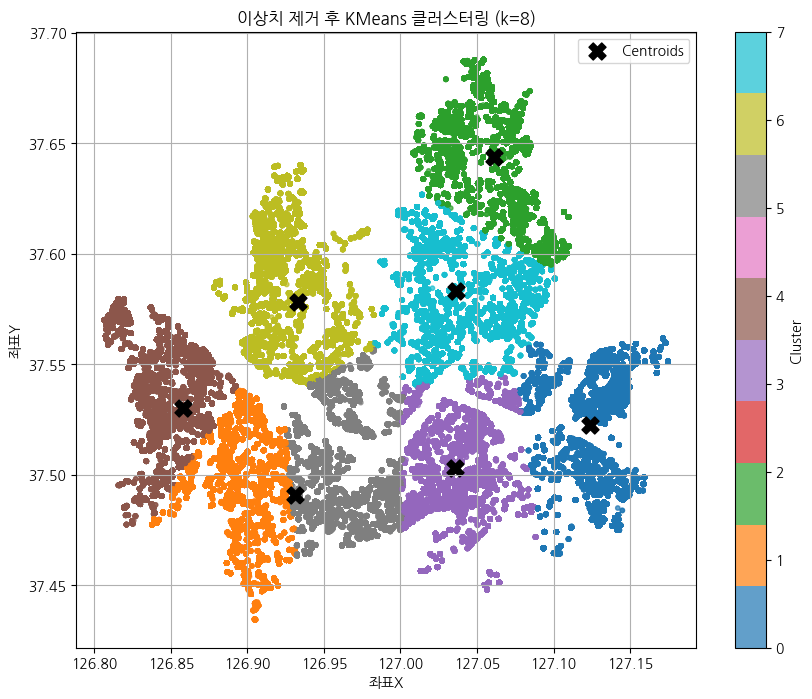

In [194]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_clean['좌표X'], df_clean['좌표Y'], c=df_clean['cluster'], cmap='tab10', s=10, alpha=0.7)
plt.xlabel('좌표X')
plt.ylabel('좌표Y')
plt.title(f'이상치 제거 후 KMeans 클러스터링 (k={k_opt})')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)

# 클러스터 중심 추가 시각화
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=150, marker='X', label='Centroids')
plt.legend()
plt.show()

이상치 제거 후 다시 군집화를 수행했다.

k값이 8일 때, 가운데 한강을 기준으로 어느정도 군집화가 잘 이루어진 것을 볼 수 있다.

cluster 특성이 생성됬으므로, 다중 공산성을 피하기 위해 좌표X와 좌표Y를 제거한다.

In [ ]:
df = df.drop(columns=['좌표X', '좌표Y'])

In [202]:
df.head(1)

,전용면적(㎡),건축년도,해제사유발생일,연면적,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),전체세대수,주차대수,계약(연),아파트명,등기신청일자,복도유형,"단지분류(아파트,주상복합등등)",도로명,세대당_주차대수,cluster,군집
0,79.97,1987,0,22637.0,20.0,250.0,270.0,262.0,2017,개포6차우성,1,계단식,아파트,언주로 3,0.97037,6,6


이제 이렇게 군집화 모델을 저장한다.

In [204]:
joblib.dump(kmeans_clean, 'kmeans_model.pkl')

['kmeans_model.pkl']

# 4. Entire Preprocessing Method

위의 전처리과정을 하나의 전처리 함수로 묶으면 다음과 같다.

마지막에는 스케일링 처리까지 적용해준다.

스케일러는 데이터가 이상치가 꽤 존재하는 데이터이므로 RobustScaler를 사용한다.

## 4.1 Preprocessing

In [206]:
def Entire_Preprocessing(df) :
    # 문자열 컬럼만 찾아서 좌우 공백 제거
    df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    # 전화번호, 팩스번호 k-홈페이지, 고용보험관리번호, k-등록일자, k-수정일자, 관리비 업로드, 단지소개기존clob 삭제
    df = df.drop(columns=['k-전화번호', 'k-팩스번호', 'k-홈페이지', '고용보험관리번호', 'k-등록일자', 'k-수정일자', '관리비 업로드', '단지소개기존clob'])

    # 본번, 부번, 시군구 삭제
    df = df.drop(columns=['본번', '부번', '시군구'])

    # 계약년월 분해
    df['계약(연)'] = df['계약년월'] // 100
    df['계약(월)'] = df['계약년월'] % 100
    df = df.drop(columns=['계약년월'])

    # 계약일 → 계약(일)
    df = df.rename(columns={"계약일" : "계약(일)"})

    # 불필요 특성 제거
    columns_to_keep = [
    '전용면적(㎡)', '건축년도', '해제사유발생일', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-전체세대수', '주차대수', '계약(연)', 
    '좌표X', '좌표Y', '아파트명', '등기신청일자', 'k-복도유형', 'k-단지분류(아파트,주상복합등등)', '도로명'
    ]

    df = df[columns_to_keep]

    # 해재사유발생일 전처리
    df['해제사유발생일'] = df['해제사유발생일'].notnull().astype(int)

    # 세대당_주차대수 특성 생성
    df['세대당_주차대수'] = df.apply(
    lambda row: row['주차대수'] / row['k-전체세대수'] if pd.notnull(row['주차대수']) and pd.notnull(row['k-전체세대수']) else np.nan,
    axis=1)

    # 등기신청일자 전처리
    df['등기신청일자'] = df['등기신청일자'].notnull().astype(int)

    # 특성 이름에서 k- 빼기
    df.columns = df.columns.str.replace('k-', '')

    # 군집화
    ## 카카오 API 호출 함수
    def get_coords_kakao(address, api_key):
        url = "https://dapi.kakao.com/v2/local/search/address.json"
        headers = {"Authorization": f"KakaoAK {api_key}"}
        params = {"query": address}
        response = requests.get(url, headers=headers, params=params)
        result = response.json()
        
        try:
            x = float(result['documents'][0]['x'])
            y = float(result['documents'][0]['y'])
            return x, y
        except IndexError:
            return None, None

    ## 도로명을 기반으로 좌표X와 좌표Y를 받아옴 (결측치에 한해서)
    def fill_missing_coords(row):
        if pd.isna(row['좌표X']) or pd.isna(row['좌표Y']):
            coords = roadname_to_coords.get(row['도로명'])
            if coords:
                return pd.Series(coords)
        return pd.Series([row['좌표X'], row['좌표Y']])
    
    roadname_to_coords = {}
    unique_roads = df.loc[df[['좌표X', '좌표Y']].isnull().any(axis=1), '도로명'].dropna().unique()

    api_key = '13b7b7a0b7a853100b56c56f19f6bc24'

    for road in tqdm(unique_roads) :
        x, y = get_coords_kakao(road, api_key)
        if x is not None and y is not None :
            roadname_to_coords[road] = (x, y)

    df[['좌표X', '좌표Y']] = df.apply(fill_missing_coords, axis=1)

In [ ]:
# 군집화
kmeans = joblib.load('kmeans_model.pkl')

df['cluster'] = kmeans.predict(df[['좌표X', '좌표Y']])
df = df.drop(columns=['좌표X', '좌표Y'])